In [98]:
import os
import pandas as pd
# from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score
# sklearn.metrics.accuracy_score
import xgboost as xgb
import numpy as np
import itertools 
import tqdm
from time import sleep
import random
# from docx import Document
# import docx2txt
import matplotlib.pyplot as plt

In [2]:
import torch

from transformers import BertTokenizer, BertForSequenceClassification, BertModel
from transformers.models.auto import AutoModelForSequenceClassification, AutoTokenizer
from torch.utils.data import DataLoader
from accelerate.utils.memory import clear_device_cache
from torch.optim import AdamW
from transformers import get_scheduler
from accelerate.test_utils.testing import get_backend
from tqdm.auto import tqdm
import evaluate

/data/project/anaconda3_test/envs/LOD/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from datasets import Dataset
# Prepare the model input features
def tokenize(batch):
    return tokenizer(batch["summarization"], padding=True, truncation=True)

In [4]:
# Please specify your model here
device, _, _ = get_backend()
model_name = "bert-base-uncased"
# model_name = "/data/project/deberta-v3-base"
if "bert" in model_name.split("-"):
    tokenizer = BertTokenizer.from_pretrained(model_name)
else:
    tokenizer = AutoTokenizer.from_pretrained(model_name)

In [5]:
# mannually generate the search grid
def makeGrid(pars_dict):  
    keys=pars_dict.keys()
    combinations=itertools.product(*pars_dict.values())
    ds=[dict(zip(keys,cc)) for cc in combinations]
    return ds

# Data Preparation

In [6]:
df_raw = pd.read_excel("../Dataset/MergedDataset_231207_ForElly_Excel.xlsx")

# Remove "." in the feature column
row_num, column_num = df_raw.shape
for rowID in range(row_num):
    for columnID in range(column_num):
        if "." == df_raw.iloc[rowID, columnID]:
            df_raw.iloc[rowID, columnID] = np.nan

# prepare the feature list
featureList = []
for item in df_raw.columns:
    if item.startswith("Item"):
        featureList.append(item)

patientList = []
roundList = []
for idx, row in df_raw.iterrows():
    patient = int(str(row["IAPTus_Num"]).split("_")[0])
    if "_" in str(row["IAPTus_Num"]):
        Round = int(str(row["IAPTus_Num"]).split("_")[1])
    else:
        Round = 0
    patientList.append(patient)
    roundList.append(Round)
df_raw["patient"] = patientList
df_raw["round"] = roundList

In [7]:
df_referral = pd.read_json("../Dataset/ReferralLetterSummary.json", lines=True)

In [8]:
df = pd.merge(df_raw, df_referral, on=["patient","round"])

# Label Preparation

# Here I use RecoveryDesc, not the EndDesc as the prediction target. EndDesc has 4 label categories and Referral Letter has only 44 data points, so it does not meet the conditions for tuning.

In [9]:
df = df[df["RecoveryDesc"] == df["RecoveryDesc"]]
df = df[(df["RecoveryDesc"].isin(["At recovery", "Not at recovery"]))]
df.reset_index().drop("index", axis=1)
print(df.shape)

labelList = []
for idx, row in df.iterrows():
    if (row["ReliableChangeDesc"] == "Reliable improvement") & (row["ReliableRecoveryDesc"] == "Reliable recovery") & (row["RecoveryDesc"] == "At recovery"):
        labelList.append(1)
    else:
        labelList.append(0)
df["labels"] = np.array(labelList, dtype=float)
labelList = ["labels"]

(43, 285)


In [10]:
df = df[["IAPTus_Num_x","patient","round","text", "summarization", "labels"]]
df = df.reset_index().drop("index", axis=1)

In [11]:
df

,IAPTus_Num_x,patient,round,text,summarization,labels
0,24804,24804,0,ASSESSMENT APPOINTMENT:\n\nStudent confirmed t...,"### Patient Background:\nNAME, a university st...",1.0
1,24813,24813,0,Assessment appointment\n\nRisk Assessment\n\nC...,"### Patient Background:\nNAME, a university st...",0.0
2,24816,24816,0,Student agrees with “Information for Students”...,### Patient Background:\nNAME is a university ...,0.0
3,24822_1,24822,1,ASSESSMENT APPOINTMENT:\n\nStudent confirmed t...,"### Summary of Patient Background, Symptoms, I...",0.0
4,24822_2,24822,2,Current thoughts/plans/intent to self-harm\n\n...,"**Patient Background:**\nNAME, a university st...",0.0
5,24828,24828,0,Assessment appointment\n\nExploration of CORE ...,"### Patient Background, Symptoms, Impacts, and...",0.0
6,24837,24837,0,Assessment appointment\n\nExploration of MDS s...,"### Summary of Patient Background, Symptoms, I...",1.0
7,24840,24840,0,[<50 min assessment included confidentiality l...,**Patient Background:**\nNAME has a history of...,1.0
8,24861,24861,0,Exploration of MDS scores and risk\nPHQ9 -16\n...,### Patient Background:\n- **Name**: NAME\n- *...,1.0
9,24864,24864,0,Teams AA Appointmen\n\n\nStudent agrees with “...,### Patient Background:\nNAME is a university ...,0.0


In [12]:
model = BertModel.from_pretrained(model_name)
model.to(device)
model.eval() 

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [13]:
print(df.iloc[0]["summarization"])

### Patient Background:
NAME, a university student, has experienced anxiety and depression since Year 9, with episodes intensifying over time. She has a history of suicidal thoughts, most recently in September/October 2022, and is currently dealing with panic attacks, self-harming thoughts, and a compulsive behavior of making herself vomit, which she has since discontinued.

### Symptoms:
- **Panic Attacks:** Increasing in frequency.
- **Self-Harming Thoughts:** To break fingers/toes or cut herself, though she hasn’t acted on these thoughts.
- **Vomiting Compulsion:** Recently stopped, but triggered by physical illness and ongoing psychological distress.
- **Generalized Anxiety Disorder (GAD):** Diagnosed.
- **Depression:** Diagnosed.
- **Compulsion Disorder:** Possible, related to anxiety post-panic attacks.

### Impacts:
- **Daily Life:** Debilitating, with sleep issues, low motivation, and difficulty managing studies.
- **Studies:** Missed university due to anxiety and sleep problem

In [15]:
inputs = tokenizer(df.iloc[0]["summarization"], return_tensors='pt', padding=True, truncation=True).to(device)
# Obtain the embeddings
with torch.no_grad():
    outputs = model(**inputs)

# Extract the last hidden state (embeddings)
last_hidden_states = outputs.last_hidden_state

In [16]:
last_hidden_states

tensor([[[-0.4240, -0.4729,  0.1749,  ..., -0.3904,  0.1683,  0.6746],
         [-0.4251,  0.0945,  0.3747,  ...,  0.4803,  0.4099,  0.9387],
         [-0.5466, -0.1073,  1.0040,  ..., -0.0079, -0.4384,  0.9937],
         ...,
         [-0.0521,  0.1972,  0.9401,  ...,  0.0353, -0.3375,  0.0844],
         [-0.4207, -0.9624,  0.2974,  ...,  0.7795,  0.3710, -0.7726],
         [-0.5115,  0.1339,  0.8192,  ...,  0.3155, -0.7401, -0.1536]]],
       device='cuda:0')

In [21]:
last_hidden_states[0][0].shape

torch.Size([768])

In [33]:
featureList = []
for idx, row in df.iterrows():
    inputs = tokenizer(row["summarization"], return_tensors='pt', padding=True, truncation=True).to(device)
    # Obtain the embeddings
    with torch.no_grad():
        outputs = model(**inputs)

    # Extract the last hidden state (embeddings)
    last_hidden_states = outputs.last_hidden_state
    featureList.append(last_hidden_states[0][0].cpu().numpy()) # Keep the CLS embedding
feat = np.array(featureList)

In [35]:
colnames = ["Feat" + str(i) for i in range(feat[0].shape[0])]
df_emb = pd.DataFrame(feat, columns=colnames)
df_emb

,Feat0,Feat1,Feat2,Feat3,Feat4,Feat5,Feat6,Feat7,Feat8,Feat9,...,Feat758,Feat759,Feat760,Feat761,Feat762,Feat763,Feat764,Feat765,Feat766,Feat767
0,-0.424009,-0.472929,0.174940,-0.559782,-0.249215,0.128138,0.663177,0.356853,0.004555,-0.601577,...,0.255128,0.106613,-0.318580,-0.201958,-0.093358,0.151164,-0.608081,-0.390353,0.168332,0.674599
1,-0.544598,-0.316653,0.084360,-0.441258,-0.281710,0.038326,0.612190,-0.034386,0.059460,-0.678481,...,0.314633,-0.143189,-0.279195,-0.406114,-0.259326,0.530659,-0.396961,-0.531388,-0.094444,0.547022
2,-0.420397,-0.486859,-0.046307,-0.655229,-0.644502,0.032500,0.590285,0.296044,-0.050753,-0.754696,...,0.521772,-0.365324,-0.131201,-0.655341,0.135279,0.358166,-0.707551,-0.497454,0.264914,0.649389
3,-0.411742,-0.444248,0.141817,-0.421760,-0.039856,-0.106717,0.420539,0.209356,0.142887,-0.828170,...,0.388211,-0.198648,-0.093197,-0.546232,-0.087427,0.369511,-0.564370,-0.313133,0.054781,0.741464
4,-0.913313,-0.425832,-0.271650,-0.693978,-0.442022,0.185812,0.803109,0.395589,0.129309,-0.664863,...,0.238117,-0.204803,-0.170330,-0.370317,-0.099899,0.360900,-0.295116,-0.288681,0.082084,0.487820
5,-0.291733,-0.399867,0.322027,-0.388301,-0.170762,-0.049316,0.594135,0.356426,0.056399,-0.928495,...,0.449295,-0.356420,-0.021260,-0.831803,-0.205715,0.376216,-0.579031,-0.301207,0.201537,0.541197
6,-0.316500,-0.528099,0.087359,-0.262632,-0.215717,-0.181384,0.742004,0.264276,0.364885,-0.905234,...,0.423588,-0.126294,-0.128183,-0.739724,-0.200701,0.362888,-0.685795,-0.469373,0.127140,0.698417
7,-0.628187,-0.575435,-0.073435,-0.452029,-0.551450,0.023211,0.593874,0.351786,-0.150875,-0.803518,...,0.285767,-0.098680,-0.228850,-0.499233,-0.224931,0.144790,-0.624771,-0.227211,0.364369,0.633868
8,-0.523898,-0.230944,-0.083636,-0.606128,-0.089692,0.281903,0.414931,0.101078,0.129068,-0.477561,...,0.330830,-0.049732,-0.513894,-0.230236,-0.063198,0.307806,-0.630313,-0.551631,0.114173,0.127619
9,-0.432513,-0.555435,0.088527,-0.446515,-0.412867,0.122805,0.495822,0.070426,0.177916,-0.878289,...,0.516200,-0.491227,-0.276911,-0.607978,-0.082252,0.686314,-0.761648,-0.379263,0.138841,0.544263


In [37]:
df_final = pd.concat([df, df_emb], axis=1)
df_final

,IAPTus_Num_x,patient,round,text,summarization,labels,Feat0,Feat1,Feat2,Feat3,...,Feat758,Feat759,Feat760,Feat761,Feat762,Feat763,Feat764,Feat765,Feat766,Feat767
0,24804,24804,0,ASSESSMENT APPOINTMENT:\n\nStudent confirmed t...,"### Patient Background:\nNAME, a university st...",1.0,-0.424009,-0.472929,0.174940,-0.559782,...,0.255128,0.106613,-0.318580,-0.201958,-0.093358,0.151164,-0.608081,-0.390353,0.168332,0.674599
1,24813,24813,0,Assessment appointment\n\nRisk Assessment\n\nC...,"### Patient Background:\nNAME, a university st...",0.0,-0.544598,-0.316653,0.084360,-0.441258,...,0.314633,-0.143189,-0.279195,-0.406114,-0.259326,0.530659,-0.396961,-0.531388,-0.094444,0.547022
2,24816,24816,0,Student agrees with “Information for Students”...,### Patient Background:\nNAME is a university ...,0.0,-0.420397,-0.486859,-0.046307,-0.655229,...,0.521772,-0.365324,-0.131201,-0.655341,0.135279,0.358166,-0.707551,-0.497454,0.264914,0.649389
3,24822_1,24822,1,ASSESSMENT APPOINTMENT:\n\nStudent confirmed t...,"### Summary of Patient Background, Symptoms, I...",0.0,-0.411742,-0.444248,0.141817,-0.421760,...,0.388211,-0.198648,-0.093197,-0.546232,-0.087427,0.369511,-0.564370,-0.313133,0.054781,0.741464
4,24822_2,24822,2,Current thoughts/plans/intent to self-harm\n\n...,"**Patient Background:**\nNAME, a university st...",0.0,-0.913313,-0.425832,-0.271650,-0.693978,...,0.238117,-0.204803,-0.170330,-0.370317,-0.099899,0.360900,-0.295116,-0.288681,0.082084,0.487820
5,24828,24828,0,Assessment appointment\n\nExploration of CORE ...,"### Patient Background, Symptoms, Impacts, and...",0.0,-0.291733,-0.399867,0.322027,-0.388301,...,0.449295,-0.356420,-0.021260,-0.831803,-0.205715,0.376216,-0.579031,-0.301207,0.201537,0.541197
6,24837,24837,0,Assessment appointment\n\nExploration of MDS s...,"### Summary of Patient Background, Symptoms, I...",1.0,-0.316500,-0.528099,0.087359,-0.262632,...,0.423588,-0.126294,-0.128183,-0.739724,-0.200701,0.362888,-0.685795,-0.469373,0.127140,0.698417
7,24840,24840,0,[<50 min assessment included confidentiality l...,**Patient Background:**\nNAME has a history of...,1.0,-0.628187,-0.575435,-0.073435,-0.452029,...,0.285767,-0.098680,-0.228850,-0.499233,-0.224931,0.144790,-0.624771,-0.227211,0.364369,0.633868
8,24861,24861,0,Exploration of MDS scores and risk\nPHQ9 -16\n...,### Patient Background:\n- **Name**: NAME\n- *...,1.0,-0.523898,-0.230944,-0.083636,-0.606128,...,0.330830,-0.049732,-0.513894,-0.230236,-0.063198,0.307806,-0.630313,-0.551631,0.114173,0.127619
9,24864,24864,0,Teams AA Appointmen\n\n\nStudent agrees with “...,### Patient Background:\nNAME is a university ...,0.0,-0.432513,-0.555435,0.088527,-0.446515,...,0.516200,-0.491227,-0.276911,-0.607978,-0.082252,0.686314,-0.761648,-0.379263,0.138841,0.544263


In [69]:
# Keep 10% data as the test data
train, test = train_test_split(df_final, test_size=0.1)
train.shape

(38, 774)

# train a xgboost

In [70]:
classifier_emb = xgb.XGBRegressor(objective="binary:logistic", random_state=42)

In [71]:
classifier_emb.fit(train[colnames], train["labels"])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, objective='binary:logistic', ...)

In [88]:
predicted_train_tfidf = classifier_emb.predict(train[colnames])
accuracy_train_tfidf = accuracy_score(train["labels"], (predicted_train_tfidf>0.5))
print('Accuracy Training data: {:.1%}'.format(accuracy_train_tfidf))

predicted_test_tfidf = classifier_emb.predict(test[colnames])
accuracy_test_tfidf = accuracy_score(test["labels"], (predicted_test_tfidf>0.5))
accuracy_tfidf = accuracy_test_tfidf
print('Accuracy Test data: {:.1%}'.format(accuracy_test_tfidf))

Accuracy Training data: 100.0%
Accuracy Test data: 20.0%


## GridSearch for Xgboost

In [73]:
param_dict = {
    "n_estimators": [10, 50, 100, 150],
    "max_depth": [4,8,10,16],
    "objective": ["binary:logistic"],
    "booster": ["gbtree"],
    "n_jobs": [5],
    'colsample_bytree': [0.3, 0.5, 0.7, 1.0],
    'colsample_bylevel': [0.3, 0.5, 0.7, 1.0],
    'colsample_bynode': [0.3, 0.5, 0.7, 1.0], 
}

In [80]:
def singleTrain(X_train, Y_train, X_val, Y_val, param):
    cls = xgb.XGBRegressor(**param, random_state=42)
    cls.fit(X_train, Y_train)
    predicted_val = classifier_emb.predict(X_val)
    accuracy_val = accuracy_score(Y_val, (predicted_val>0.5))
    result = {}
    # result["train_acc"] = accuracy_train_tfidf
    result["test_acc"] = accuracy_val
    return result

In [89]:
def CVTrain(Train, param):
    FinalResult = {}
    FinalResult["details"] = []
    skf = StratifiedKFold(n_splits=5)
    for i, (train_index, val_index) in enumerate(skf.split(train["summarization"], train["labels"])):
        (X_train, Y_train) = train.iloc[train_index][colnames].values, train.iloc[train_index]["labels"].values.squeeze()
        (X_val, Y_val) = train.iloc[val_index][colnames].values, train.iloc[val_index]["labels"].values.squeeze()
        # print(X_train, Y_train)
        
        result = singleTrain(X_train, Y_train, X_val, Y_val, param)
        
        FinalResult["details"].append(result)
    FinalResult["acc_mean"] = np.mean([x["test_acc"] for x in FinalResult["details"]])
    FinalResult["acc_std"] = np.std([x["test_acc"] for x in FinalResult["details"]])
    return FinalResult

In [90]:
def MyGridSearch(param_dict, train):
    searchSpace = makeGrid(param_dict)
    print("Search Space Size:" + len(searchSpace).__str__())
    resultList = []
    for param in tqdm.tqdm(searchSpace):
        #sleep(1)
        result = CVTrain(train, param)
        result["param"] = param
        resultList.append(result)
    sortedResult = sorted(resultList, key=lambda x: x["acc_mean"], reverse=True)
    print(sortedResult[:5])
    return sortedResult

In [91]:
SearchResult = MyGridSearch(param_dict, train)

Search Space Size:1024


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1024/1024 [01:07<00:00, 15.12it/s]

[{'details': [{'test_acc': 1.0}, {'test_acc': 1.0}, {'test_acc': 1.0}, {'test_acc': 1.0}, {'test_acc': 1.0}], 'acc_mean': 1.0, 'acc_std': 0.0, 'param': {'n_estimators': 10, 'max_depth': 4, 'objective': 'binary:logistic', 'booster': 'gbtree', 'n_jobs': 5, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.3, 'colsample_bynode': 0.3}}, {'details': [{'test_acc': 1.0}, {'test_acc': 1.0}, {'test_acc': 1.0}, {'test_acc': 1.0}, {'test_acc': 1.0}], 'acc_mean': 1.0, 'acc_std': 0.0, 'param': {'n_estimators': 10, 'max_depth': 4, 'objective': 'binary:logistic', 'booster': 'gbtree', 'n_jobs': 5, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.3, 'colsample_bynode': 0.5}}, {'details': [{'test_acc': 1.0}, {'test_acc': 1.0}, {'test_acc': 1.0}, {'test_acc': 1.0}, {'test_acc': 1.0}], 'acc_mean': 1.0, 'acc_std': 0.0, 'param': {'n_estimators': 10, 'max_depth': 4, 'objective': 'binary:logistic', 'booster': 'gbtree', 'n_jobs': 5, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.3, 'colsample_bynode': 0.7}}, {'d

In [93]:
param = {
    'n_estimators': 10, 
    'max_depth': 4, 
    'objective': 'binary:logistic', 
    'booster': 'gbtree', 
    'n_jobs': 5, 
    'colsample_bytree': 0.3, 
    'colsample_bylevel': 0.3, 
    'colsample_bynode': 0.3
}

In [94]:
classifier_emb = xgb.XGBRegressor(**param)
classifier_emb.fit(train[colnames], train["labels"])

predicted_train_tfidf = classifier_emb.predict(train[colnames])
accuracy_train_tfidf = accuracy_score(train["labels"], (predicted_train_tfidf>0.5))
print('Accuracy Training data: {:.1%}'.format(accuracy_train_tfidf))

predicted_test_tfidf = classifier_emb.predict(test[colnames])
accuracy_test_tfidf = accuracy_score(test["labels"], (predicted_test_tfidf>0.5))
accuracy_tfidf = accuracy_test_tfidf
print('Accuracy Test data: {:.1%}'.format(accuracy_test_tfidf))

Accuracy Training data: 100.0%
Accuracy Test data: 40.0%


In [96]:
AccList = []
for i in range(100):
    # Keep 10% data as the test data
    train, test = train_test_split(df_final, test_size=0.1)
    train.shape

    classifier_emb = xgb.XGBRegressor(**param)
    classifier_emb.fit(train[colnames], train["labels"])

    predicted_test_tfidf = classifier_emb.predict(test[colnames])
    accuracy_test_tfidf = accuracy_score(test["labels"], (predicted_test_tfidf>0.5))

    AccList.append(accuracy_test_tfidf)

print(AccList)

[0.4, 0.6, 0.2, 0.0, 0.4, 0.6, 0.4, 0.4, 0.2, 0.6, 0.6, 0.6, 0.4, 0.4, 0.4, 0.8, 0.4, 0.4, 0.4, 0.2, 0.8, 0.6, 0.2, 0.8, 0.2, 0.4, 0.4, 0.6, 0.4, 0.8, 0.2, 0.4, 0.6, 0.6, 0.4, 0.6, 0.6, 0.6, 0.8, 0.6, 0.4, 0.6, 0.4, 0.6, 0.6, 0.2, 0.6, 0.2, 0.4, 0.8, 0.6, 0.6, 0.4, 0.6, 0.6, 0.6, 0.6, 0.4, 0.6, 0.6, 0.2, 0.4, 0.8, 0.4, 0.6, 0.4, 0.4, 0.0, 0.4, 0.4, 0.6, 0.6, 0.2, 0.8, 0.6, 0.2, 0.4, 0.8, 0.4, 0.6, 0.6, 0.6, 0.4, 0.0, 0.4, 0.2, 0.4, 0.4, 0.8, 0.8, 0.4, 0.8, 0.6, 0.4, 0.6, 0.6, 0.6, 0.4, 0.2, 0.6]


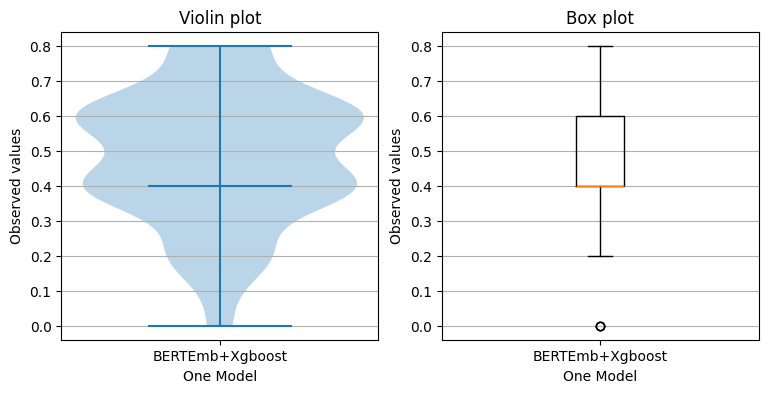

In [99]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
# plot violin plot
axs[0].violinplot([AccList],
                  showmeans=False,
                  showmedians=True)
axs[0].set_title('Violin plot')

# plot box plot
axs[1].boxplot([AccList])
axs[1].set_title('Box plot')

for ax in axs:
    ax.yaxis.grid(True)
    ax.set_xticks([y + 1 for y in range(len([AccList]))],
                  labels=['BERTEmb+Xgboost'])
    ax.set_xlabel('One Model')
    ax.set_ylabel('Observed values')

plt.show()

In [100]:
AccList = []
for i in range(100):
    # Keep 10% data as the test data
    train, test = train_test_split(df_final, test_size=0.1)
    train.shape

    classifier_emb = xgb.XGBRegressor(objective="binary:logistic")
    classifier_emb.fit(train[colnames], train["labels"])

    predicted_test_tfidf = classifier_emb.predict(test[colnames])
    accuracy_test_tfidf = accuracy_score(test["labels"], (predicted_test_tfidf>0.5))

    AccList.append(accuracy_test_tfidf)

print(AccList)

[0.4, 0.0, 0.2, 0.4, 0.2, 0.4, 0.4, 0.8, 0.6, 0.4, 0.6, 0.6, 0.2, 0.6, 0.6, 0.2, 0.0, 0.6, 0.4, 0.4, 0.6, 0.4, 0.0, 0.2, 0.4, 0.2, 0.6, 0.4, 0.8, 0.6, 0.4, 0.6, 0.4, 0.6, 0.6, 0.4, 0.8, 0.6, 0.6, 0.4, 0.4, 0.2, 0.4, 1.0, 0.0, 0.4, 0.6, 0.2, 0.4, 0.4, 0.4, 0.6, 0.2, 0.6, 0.4, 0.6, 0.6, 0.6, 0.6, 0.6, 0.8, 0.4, 0.6, 0.4, 0.4, 0.6, 0.4, 0.2, 0.4, 0.2, 0.6, 0.6, 0.2, 0.6, 0.6, 0.0, 0.6, 0.4, 0.4, 0.6, 0.6, 0.4, 0.6, 0.0, 0.4, 0.4, 0.4, 0.6, 0.4, 0.4, 0.4, 0.4, 0.6, 0.4, 0.6, 0.4, 0.2, 0.0, 0.4, 0.4]


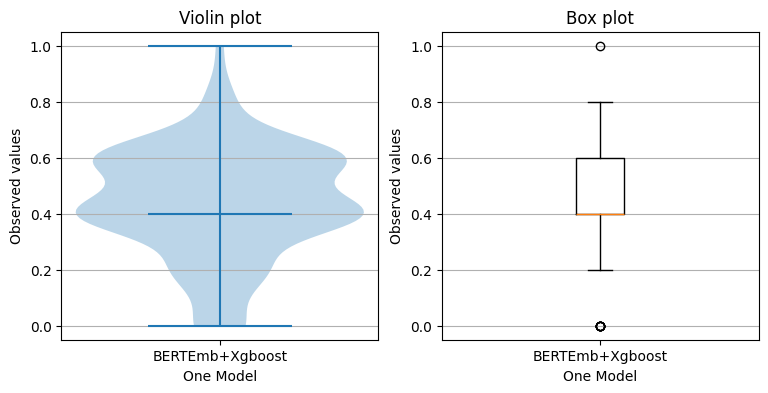

In [101]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
# plot violin plot
axs[0].violinplot([AccList],
                  showmeans=False,
                  showmedians=True)
axs[0].set_title('Violin plot')

# plot box plot
axs[1].boxplot([AccList])
axs[1].set_title('Box plot')

for ax in axs:
    ax.yaxis.grid(True)
    ax.set_xticks([y + 1 for y in range(len([AccList]))],
                  labels=['BERTEmb+Xgboost'])
    ax.set_xlabel('One Model')
    ax.set_ylabel('Observed values')

plt.show()